In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups

# Gensim
#!pip install --upgrade gensim
#!pip install gensim==3.8.3
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#nltk
import nltk
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

# wordcloud
#from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sundaracharya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import spacy
from spacy.lang.en.examples import sentences

In [3]:
newsgroups_data = fetch_20newsgroups(subset='all',random_state=32,shuffle=True,remove=('headers', 'footers', 'qutes'))
newsgroups_train = fetch_20newsgroups(subset='train',random_state=32,shuffle=True , remove=('headers', 'footers', 'qutes'))
newsgroups_test = fetch_20newsgroups(subset='test',random_state=32,shuffle=True , remove=('headers', 'footers', 'qutes'))

In [4]:
df_train = pd.DataFrame({'News':newsgroups_train.data,'Target':newsgroups_train.target})
df_train['Target_name'] = df_train['Target'].apply(lambda x:newsgroups_train.target_names[x])
df_train.head()

,News,Target,Target_name
0,The real question here in my opinion is what M...,4,comp.sys.mac.hardware
1,Please could someone in the US give me the cur...,4,comp.sys.mac.hardware
2,Can somebody please help me with information a...,12,sci.electronics
3,In article <2077@rwing.UUCP> pat@rwing.UUCP (P...,16,talk.politics.guns
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7,rec.autos


In [28]:
df_test = pd.DataFrame({'News':newsgroups_test.data,'Target':newsgroups_test.target})
df_test['Target_name'] = df_test['Target'].apply(lambda x:newsgroups_test.target_names[x])
df_test.head()

,News,Target,Target_name
0,Radio Shack stores sell them here in the State...,12,sci.electronics
1,Has anyone else observed this behaviour and if...,2,comp.os.ms-windows.misc
2,D. Andrew Byler (db7n+@andrew.cmu.edu) wrote:\...,15,soc.religion.christian
3,Again I assume this is not just flame bait by ...,10,rec.sport.hockey
4,In article <1993Apr21.100149.1501@rtsg.mot.com...,7,rec.autos


In [29]:
df_test.shape

(7532, 3)

In [31]:
#df_validation = 
import numpy as np
fractions = np.array([0.5,0.5])
df_validation, df_final_test= np.array_split(df_test, (fractions[:-1].cumsum() * len(df_test)).astype(int))

In [32]:
print(df_validation.shape,df_final_test.shape)

(3766, 3) (3766, 3)


# Preprocessing

### remove senders info and blank/newline characters

In [5]:
news_train_data = df_train.News.values.tolist()

In [6]:
# removing new line
news_train_data = [re.sub('\s+', ' ', sent) for sent in news_train_data]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/4t/2rm5x3sn057fc9fch2_h0p_c0000gn/T/ipykernel_52372/3435132558.py:2: DeprecationWarning: invalid escape sequence \s
  news_train_data = [re.sub('\s+', ' ', sent) for sent in news_train_data]


In [7]:
# removing emails
news_train_data = [re.sub('\S*@\S*\s?', '', sent) for sent in news_train_data]

<>:2: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \S
/var/folders/4t/2rm5x3sn057fc9fch2_h0p_c0000gn/T/ipykernel_52372/719524970.py:2: DeprecationWarning: invalid escape sequence \S
  news_train_data = [re.sub('\S*@\S*\s?', '', sent) for sent in news_train_data]


In [8]:
# removing single quotes
news_train_data = [re.sub("\'", "", sent) for sent in news_train_data]

In [9]:
news_train_data[0]

'The real question here in my opinion is what Motorola processors running system 7 on a MAC are comparable to what Intel processors running Windows on a PC? I recall there being a conversation here that a 486/25 running Windows benchmarks at about the same speed as 25Mhz 030 in system 7. I dont know if that is true, but I would love to hear if anyone has any technical data on this. -David'

## stopwords

In [19]:
#stopwords
stop_words = gensim.parsing.preprocessing.STOPWORDS
extra_stop_words = frozenset(['from', 'subject', 're', 'edu', 'use'])
stop_words.union(extra_stop_words)

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'


### Lemmatization and stemming

In [12]:
# lemmatization
stemmer = PorterStemmer()
def lemmatize_stem(tokendata):
  return stemmer.stem(WordNetLemmatizer().lemmatize(tokendata,pos='v'))

# Tokenize and lemmatize
def tokenLemm(data):
    result=[]
    for token in gensim.utils.simple_preprocess(data) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
          result.append(lemmatize_stem(token))
    return result

In [13]:
def convertedData(data):
    datalist = []
    for d in data:
        datalist.append(tokenLemm(d))
    return datalist

In [14]:
df_train['News1']=convertedData(news_train_data)

In [15]:
#data preview
df_train

,News,Target,Target_name,News1
0,The real question here in my opinion is what M...,4,comp.sys.mac.hardware,"[real, question, opinion, motorola, processor,..."
1,Please could someone in the US give me the cur...,4,comp.sys.mac.hardware,"[current, street, price, follow, relev, tax, s..."
2,Can somebody please help me with information a...,12,sci.electronics,"[somebodi, help, inform, american, magnet, cor..."
3,In article <2077@rwing.UUCP> pat@rwing.UUCP (P...,16,talk.politics.guns,"[articl, rwing, uucp, rwing, uucp, myrto, writ..."
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7,rec.autos,"[articl, news, john, daker, holder, drive, imp..."
...,...,...,...,...
11309,In article <1qvs9t$q3f@usenet.INS.CWRU.Edu> Ch...,4,comp.sys.mac.hardware,"[articl, usenet, cwru, charl, snowhit, eeap, c..."
11310,"Hi,\nI've got a Multi I/O card (IDE controller...",3,comp.sys.ibm.pc.hardware,"[multi, card, control, serial, parallel, inter..."
11311,\n As a person who has rarely even SEEN Do...,10,rec.sport.hockey,"[person, rare, see, cherri, know, know, area, ..."
11312,>> So they should sue the newspaper I got it f...,1,comp.graphics,"[newspap, print, articl, copyright, sure, news..."


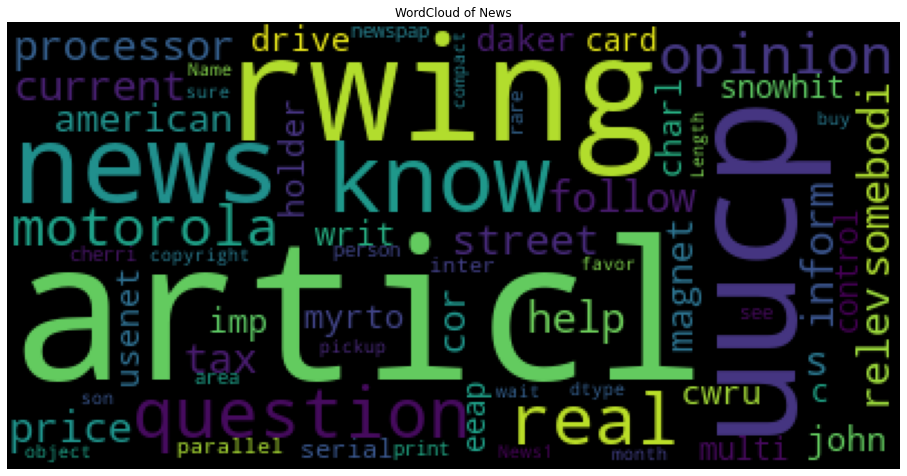

In [16]:
# plot word count for news text
#!pip install wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='black',max_words=200).generate(str(df_train['News1']))
fig = plt.figure(figsize=[16,16])
plt.title('WordCloud of News')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

## STOPWORDS, bigrams, and trigrams

In [20]:
#df['News1']
processed_data = df_train['News1']
#bigrams
bigram = gensim.models.Phrases(processed_data,min_count=5, threshold = 100)
bigram_model = gensim.models.phrases.Phraser(bigram)
#trigram
trigram = gensim.models.Phrases(bigram[processed_data],threshold=100)
trigram_model = gensim.models.phrases.Phraser(trigram)

def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
   return [bigram_model[doc] for doc in texts]
def make_trigrams(texts):
   return [trigram_model[bigram_model[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out
data_words_nostops = remove_stopwords(processed_data)
data_words_bigrams = make_bigrams(data_words_nostops)

In [21]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=[
   'NOUN', 'ADJ', 'VERB', 'ADV'
])
print(data_lemmatized[:1]) #let's see the first document lemmatized data

[['real', 'question', 'opinion', 'motorola', 'processor', 'run', 'processor', 'run', 'window', 'recal', 'conver', 'run', 'window', 'benchmark', 'speed', 'know', 'true', 'love', 'hear', 'technic', 'datum']]


## Creating dictionary and corpus

In [23]:
# Create Dictionary 
#id2word = corpora.Dictionary(df['News1'])  
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]
# View 
#corpus_train_val = corpus[:int(len(corpus)*0.8)]
#print(corpus[:1])

In [24]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the keyword of topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.121*"return" + 0.108*"jesu" + 0.062*"bike" + 0.044*"boot" + 0.035*"separ" + 0.031*"ride" + 0.028*"evil" + 0.027*"truck" + 0.025*"hole" + 0.024*"profit"'), (1, '0.153*"list" + 0.119*"mail" + 0.067*"address" + 0.063*"stuff" + 0.039*"theori" + 0.038*"request" + 0.038*"newsgroup" + 0.036*"post" + 0.027*"mark" + 0.023*"creation"'), (2, '0.191*"object" + 0.126*"moral" + 0.089*"defin" + 0.074*"repli" + 0.063*"definit" + 0.045*"room" + 0.034*"impli" + 0.027*"self" + 0.027*"cod" + 0.024*"crash"'), (3, '0.036*"file" + 0.028*"program" + 0.024*"inform" + 0.019*"avail" + 0.017*"send" + 0.016*"email" + 0.015*"line" + 0.014*"number" + 0.014*"type" + 0.014*"build"'), (4, '0.032*"peopl" + 0.020*"true" + 0.019*"live" + 0.018*"fact" + 0.017*"person" + 0.016*"mean" + 0.016*"claim" + 0.015*"argument" + 0.015*"exist" + 0.015*"believ"'), (5, '0.075*"water" + 0.055*"food" + 0.050*"tire" + 0.050*"predict" + 0.048*"defend" + 0.044*"brake" + 0.044*"hurt" + 0.041*"door" + 0.029*"drink" + 0.029*"wheel"'), 

In [25]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
#coherence_model_lda = CoherenceModel(model=lda_model, texts=df['News1'], dictionary=id2word, coherence='c_v')
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.881403399081634

Coherence Score:  0.39795084390933944
